<script async src="https://www.googletagmanager.com/gtag/js?id=UA-59152712-8"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-59152712-8');
</script>

# Sommerfeld Boundary Conditions

<font color='green'><b> Validated for all coordinate systems available in NRPy+ </b></font>

## Authors: Terrence Pierre Jacques & Zach Etienne

## Abstract

The aim of this notebook is to describe the mathematical motivation behind the Sommerfeld boundary condition, document how it is implemented within the NRPy+ infrastructure in Cartesian coordinates, and record ongoing validation tests against the [Einstein Toolkit's NewRad boundary condition driver](https://www.einsteintoolkit.org/thornguide/EinsteinEvolve/NewRad/documentation.html#XEinsteinEvolve_NewRad_Alcubierre:2002kk).

**Notebook Status:** <font color='green'><b> Validated against the Einstein Toolkit </b></font>

**Validation Notes:** The Sommerfeld boundary condition as implemented in NRPy+ has been validated against [Einstein Toolkit's NewRad boundary condition driver](https://www.einsteintoolkit.org/thornguide/EinsteinEvolve/NewRad/documentation.html#XEinsteinEvolve_NewRad_Alcubierre:2002kk)(ETK) for the case of a scalar wave propagating across a 3D Cartesian grid. We have agreement to roundoff error with the Einstein Toolkit. Specifically, we have achieved:

1. Roundoff level agreement for the wave propagating toward each of the individual faces

1. Roundoff level agreement using any combination of input parameters available in the [Einstein Toolkit's NewRad boundary condition driver](https://www.einsteintoolkit.org/thornguide/EinsteinEvolve/NewRad/documentation.html#XEinsteinEvolve_NewRad_Alcubierre:2002kk) (variable value at infinity, radial power, and wave speed)

[comment]: <> (Introduction: TODO)

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

This notebook is organized as follows

1. [Step 1](#initializenrpy): Set core NRPy+ parameters for numerical grids 
1. [Step 2](#sbc): Definition and mathematical motivation
    1. [Step 2.a](#intro): Introduction & background mathematics
    1. [Step 2.b](#sbc_prelims): Preliminaries - The scalar wave equation in curvilinear coordinates
    1. [Step 2.c](#sbc_ansatz): Sommerfeld boundary condition ansatz
    1. [Step 2.d](#sbc_ansatz_dtf): Applying the ansatz to $\partial_t f$
    1. [Step 2.e](#curvicoords): Implementation in generic curvilinear coordinates
        1. [Step 2.e.i](#cartcoords_byhand): Sommerfeld boundary conditions implementation in Cartesian coordinates, derived by hand
        1. [Step 2.e.ii](#cartcoords_bynrpysympy): Sommerfeld boundary conditions implementation in Cartesian coordinates, derived by NRPy+/SymPy
1. [Step 3](#numalg): Numerical algorithm overview
    1. [Step 3.a](#class): Sommerfeld python class and parameters
    1. [Step 3.b](#partial_rf): Calculate $\partial_r f$
    1. [Step 3.c](#cfunc): `apply_bcs_sommerfeld()` C function
    1. [Step 3.d](#k): Solving for the subdominant radial falloff proportionality constant $k$
    1. [Step 3.e](#innerbcs): Inner Boundary Conditions
1. [Step 4](#py_validate): Python file validation
1. [Step 5](#interface): NRPy+ Interface for Applying Sommerfeld Boundary Conditions
1. [Step 6](#etk_validation): Validation against the [Einstein Toolkit's NewRad boundary condition driver](https://www.einsteintoolkit.org/thornguide/EinsteinEvolve/NewRad/documentation.html#XEinsteinEvolve_NewRad_Alcubierre:2002kk)
1. [Latex Output](#latex_pdf_output): Output this notebook to $\LaTeX$-formatted PDF file

<a id='initializenrpy'></a>

# Step 1: Set core NRPy+ parameters for numerical grids \[Back to [top](#toc)\]
$$\label{initializenrpy}$$

Import needed NRPy+ core modules and set working directories.

In [1]:
# Step P1: Import needed NRPy+ core modules:
import NRPy_param_funcs as par   # NRPy+: Parameter interface
import reference_metric as rfm  # NRPy+: Reference metric support
import grid as gri               # NRPy+: Functions having to do with numerical grids
import cmdline_helper as cmd     # NRPy+: Multi-platform Python command-line interface
import shutil, os, sys           # Standard Python modules for multiplatform OS-level functions

# Create C code output directory:
Ccodesdir = os.path.join("SommerfeldBoundaryCondition_Validate")
# First remove C code output directory if it exists
# Courtesy https://stackoverflow.com/questions/303200/how-do-i-remove-delete-a-folder-that-is-not-empty
shutil.rmtree(Ccodesdir, ignore_errors=True)
# Then create a fresh directory
cmd.mkdir(Ccodesdir)

par.set_parval_from_str("grid::DIM",3)
DIM = par.parval_from_str("grid::DIM")

<a id='sbc'></a>

# Step 2: Sommerfeld Boundary Conditions \[Back to [top](#toc)\]
$$\label{sbc}$$

<a id='intro'></a>

## Step 2.a: Introduction & background mathematics \[Back to [top](#toc)\]
$$\label{intro}$$


When we numerically solve an initial value problem, appropriate initial data must be provided, coupled to a technique for evolving the initial data forward in time (to construct the solution at $t>0$), and we must impose boundary conditions. 

The subject of this notebook is implementation of Sommerfeld boundary conditions, which are often used when solving hyperbolic systems of partial differential equations (PDEs). Sommerfeld boundary conditions are also referred to as a radiation or transparent boundary conditions. 

The essential idea of a transparent boundary is creating a boundary in which wave fronts can pass through with minimal reflections. In other words, the boundary condition acts to map our numerical solution to outside our numerical domain in a smooth fashion. Because this mapping is assumed to be linear, this treatment occurs at the same time-level as calculations within our numerical domain. This point will be revisited later.

Suppose we have a dynamical variable $f$; i.e., a variable in our hyperbolic system of PDEs that satisfies the equation

$$
\partial_t f = \text{something},
$$
where generally we refer to "something" as the "right-hand side" or "RHS" of the hyperbolic PDE, where we formulate the PDE such that the RHS contains no explicit time derivatives, but generally does contain spatial derivatives (typically computed in NRPy+ using finite differencing, though may in general be computed using other, e.g., pseudospectral techniques).

To construct the solution at times after the initial data, we adopt the [Method of Lines (MoL)](Tutorial-ScalarWave.ipynb) approach, which integrates the equations forward *in time* using standard explicit techniques typically used when solving *ordinary* differential equations. In doing so, MoL evaluates the RHS of the PDE at all points in our numerical domain (typically using finite difference derivatives), except the ghost zones (i.e., the gridpoints neighboring the precise point needed to evaluate a derivative using e.g., a finite difference derivative).

After each RHS evaluation we must fill in the data on the boundaries (i.e., the ghost zones), so that data exist at all gridpoints (including the boundaries) at the next MoL substep. In doing so, we have two options:

1. Perform an MoL substep to push the *interior* solution $f$ forward in time one substep, and then update the boundary values of $f$.
1. During the MoL substep, immediately after evaluating the RHS of the $\partial t f$ equation, update the boundary values of the RHS of the $\partial t f$ equation. Then push the solution $f$ forward in time *at all gridpoints, including ghost zones* by one substep.

Our implementation of the Sommerfeld boundary condition implements the second option, filling in the data for $\partial_t f$ (cf., our [extrapolation boundary condition implementation](Tutorial-Start_to_Finish-Curvilinear_BCs.ipynb)) on the boundaries (i.e., ghost zones).

<a id='sbc_prelims'></a>

## Step 2.b: Preliminaries - The scalar wave equation in curvilinear coordinates \[Back to [top](#toc)\]
$$\label{sbc_prelims}$$

Our Sommerfeld boundary condition implementation assumes $f$ behaves as a spherically symmetric, outgoing wave at the boundaries. Under these assumptions, the waves satisfy the wave equation in spherical coordinates with angular parts set to zero. I.e., under these assumptions the wavefunction $u(r,t)$ will satisfy:

\begin{align}
0 = \Box\, u &= \hat{D}^{\nu} \hat{D}_{\nu} u \\
&= \hat{g}^{\mu\nu} \hat{D}_{\mu} \hat{D}_{\nu} u \\
&= \hat{g}^{\mu\nu} \hat{D}_{\mu} \partial_{\nu} u \\
&= \hat{g}^{\mu\nu} \left[\partial_{\mu} (\partial_{\nu} u) - \hat{\Gamma}^\alpha_{\mu\nu} (\partial_{\alpha} u) \right],
\end{align}
here the hatted metric is defined as $\hat{g}^{tt} = -1/v^2$ (where $v$ is the wavespeed), $\hat{g}^{rr}=1$, $\hat{g}^{\theta\theta}=1/r^2$, and $\hat{g}^{\phi\phi}=1/(r^2\sin^2\theta)$ are the only nonzero metric terms for the spherical (contravariant) metric. However, the fact that $u=u(r,t)$ does not depend on the angular pieces greatly simplifies the expression:

\begin{align}
\Box\, u
&= \hat{g}^{\mu\nu} \left[\partial_{\mu} (\partial_{\nu} u) - \hat{\Gamma}^\alpha_{\mu\nu} (\partial_{\alpha} u) \right] \\
&= \left(-\frac{1}{v^2}\partial_t^2 + \partial_r^2\right)u - \hat{\Gamma}^\alpha_{\mu\nu} (\partial_{\alpha} u) \\
&= \left(-\frac{1}{v^2}\partial_t^2 + \partial_r^2\right)u - \hat{g}^{\mu\nu} \left[\hat{\Gamma}^t_{\mu\nu} \partial_{t} + \hat{\Gamma}^r_{\mu\nu} \partial_{r}\right]u.
\end{align}

We will now refer the reader to the [scalar wave in curvilinear coordinates notebook](Tutorial-ScalarWaveCurvilinear.ipynb) for the remainder of the derivation. The bottom line is, after removing terms implying angular variation in $u$, one obtains the wave equation for spherically symmetric waves:

$$
\frac{1}{v^2} \partial_t^2 u = \partial_r^2 u + \frac{2}{r} \partial_r u,
$$
which has the general solution

$$
u(r,t) = A \frac{u(r + vt)}{r} + B \frac{u(r - vt)}{r},
$$
where the (left) right term represents an (ingoing) outgoing wave. 

<a id='sbc_ansatz'></a>

## Step 2.c: Sommerfeld boundary condition ansatz \[Back to [top](#toc)\]
$$\label{sbc_ansatz}$$

Inspired by the solution to the scalar wave equation, our Sommerfeld boundary condition will assume the solution $f(r,t)$ acts as an *outgoing* spherical wave ($A=0$), with an asymptotic value $f_0$ at $r\to\infty$ and a correction term for incoming waves or transient non-wavelike behavior at the boundaries, with $r^n$ falloff (ignoring higher-order radial falloffs):

$$
f = f_0 + \frac{u(r-vt)}{r} + \frac{c}{r^n},
$$
where $c$ is a constant.

<a id='sbc_ansatz_dtf'></a>

## Step 2.d: Applying the ansatz to $\partial_t f$ \[Back to [top](#toc)\]
$$\label{sbc_ansatz_dtf}$$

As described in the above section, we will not apply Sommerfeld boundary conditions to $f$ but $\partial_t f$ instead:

$$
\partial_t f = -v \frac{u'(r-vt)}{r}.
$$

To get a better understanding of the $u'(r-vt)$ term, let's compute the radial partial derivative as well:

\begin{align}
\partial_r f &= \frac{u'(r-vt)}{r} - \frac{u(r-vt)}{r^2} - n \frac{c}{r^{n+1}} \\
\implies \frac{u'(r-vt)}{r} &= \partial_r f + \frac{u(r-vt)}{r^2} + n \frac{c}{r^{n+1}}
\end{align}

Thus we get

\begin{align}
\partial_t f &= -v \frac{u'(r-vt)}{r} \\
&= -v \left[\partial_r f + \frac{u(r-vt)}{r^2} + n \frac{c}{r^{n+1}} \right]
\end{align}

To take care of the (as-yet) unknown $\frac{u(r-vt)}{r^2}$ term, notice our ansatz

$$
f = f_0 + \frac{u(r-vt)}{r} + \frac{c}{r^n}
$$
implies that

\begin{align}
\frac{f - f_0}{r} &= \frac{u(r-vt)}{r^2} + \frac{c}{r^{n+1}} \\
\implies \frac{u(r-vt)}{r^2} &= \frac{f - f_0}{r} - \frac{c}{r^{n+1}}
\end{align}

so we have

\begin{align}
\partial_t f &= -v \left[\partial_r f + \frac{u(r-vt)}{r^2} + n \frac{c}{r^{n+1}} \right]\\
&= -v \left[\partial_r f + \frac{f - f_0}{r} - \frac{c}{r^{n+1}} + n \frac{c}{r^{n+1}} \right] \\
&= -v \left[\partial_r f + \frac{f - f_0}{r}\right] + \frac{k}{r^{n+1}},
\end{align}
where $k=-v c(n-1)$ is just another constant.

Thus we have derived our boundary condition:

$$
\boxed{
\partial_t f = -\frac{v}{r} \left[r \partial_r f + (f - f_0)\right] + \frac{k}{r^{n+1}}.
}
$$

<a id='curvicoords'></a>

## Step 2.e: Implementation in generic curvilinear coordinates \[Back to [top](#toc)\]
$$\label{curvicoords}$$

The core equation
$$
\boxed{
\partial_t f = -\frac{v}{r} \left[r \partial_r f + (f - f_0)\right] + \frac{k}{r^{n+1}}.
}
$$

is implemented in NRPy+ using its `reference_metric.py` module ([Tutorial notebook](Tutorial-Reference_Metric.ipynb)), as this module requires *all* coordinate systems to define the spherical coordinate $r$ in terms of input quantities `(xx0,xx1,xx2)`. Thus we need only rewrite the above equation in terms of `(xx0,xx1,xx2)`. Defining $x^i$=`(xx0,xx1,xx2)`, we have, using the chain rule:

\begin{align}
\partial_t f &= -\frac{v}{r} \left[r \partial_r f + (f - f_0)\right] + \frac{k}{r^{n+1}} \\
&= -\frac{v}{r(x^i)} \left[r \frac{\partial x^i}{\partial r} \partial_i f + (f - f_0)\right] + \frac{k}{r^{n+1}}.
\end{align}

$\frac{\partial x^i}{\partial r}$ can be impossible to compute directly, as we are given $r(x^i)$ but not necessarily $x^i(r)$. The key here is to note that we are actually given $x^j_{\rm Sph} = (r(x^i),\theta(x^i),\phi(x^i))$ for all coordinate systems, so we can define the Jacobian

$$\frac{\partial x^j_{\rm Sph}(x^i)}{\partial x^i},$$

and NRPy+ can invert this matrix to give us

$$\frac{\partial x^i}{\partial x^j_{\rm Sph}},$$

In summary, the implementation of Sommerfeld boundary conditions in arbitrary curvilinear coordinates $x^i=$`(xx0,xx1,xx2)` is given by
$$
\boxed{
\partial_t f = -\frac{v}{r(x^i)} \left[r(x^i) \frac{\partial x^i}{\partial r} \partial_i f + (f - f_0)\right] + \frac{k}{r^{n+1}}.
}
$$

In the next subsections, we'll work through implementation of this general equation in the special case of Cartesian coordinates, first by hand, and then *automatically*, for Cartesian *or other curvilinear coordinate systems supported by NRPy+* using `reference_metric.py`.

<a id='cartcoords_byhand'></a>

### Step 2.e.i: Sommerfeld boundary conditions implementation in Cartesian coordinates, derived by hand \[Back to [top](#toc)\]
$$\label{cartcoords_byhand}$$

Let's now work this out for Cartesian coordinates in NRPy+, first by hand, and then using `reference_metric.py`:

In Cartesian coordinates $\frac{\partial f}{\partial r}$ may be expanded as

$$
\frac{\partial f}{\partial r} = \frac{\partial x}{\partial r} \partial_x f + \frac{\partial y}{\partial r}\partial_y f + \frac{\partial z}{\partial r}\partial_z f.
$$

Defining $x^i$ to be the $i$th component of the Cartesian reference metric, we have

\begin{align}
x^0 = x &= r\sin\theta \cos\phi \implies \frac{\partial x}{\partial r}=\frac{x}{r}, \\
x^1 = y &= r\sin\theta \sin\phi \implies \frac{\partial y}{\partial r}=\frac{y}{r}, \\
x^2 = z &= r\cos\theta \implies \frac{\partial z}{\partial r}=\frac{z}{r}.
\end{align}

Based on this, we can rewrite the above as

\begin{align}
\frac{\partial f}{\partial r} 
&= \frac{x}{r} \partial_x f +\frac{y}{r} \partial_y f +\frac{z}{r} \partial_z f \\
&= \frac{x^0}{r} \partial_0 f +\frac{x^1}{r} \partial_1 f +\frac{x^2}{r} \partial_2 f \\
&= \frac{x^i}{r} \partial_i f,
\end{align}

yielding the Sommerfeld boundary condition in *Cartesian coordinates*

$$
\partial_t f = -\frac{v}{r} \left[x^i \partial_i f + \left( f - f_0 \right) \right] + \frac{k}{r^{n+1}}.
$$

<a id='cartcoords_bynrpysympy'></a>

### Step 2.e.ii: Sommerfeld boundary conditions implementation in Cartesian coordinates, derived automatically by NRPy+/SymPy \[Back to [top](#toc)\]
$$\label{cartcoords_bynrpysympy}$$

Now let's use NRPy+'s `reference_metric.py` to obtain the same expression for $\frac{\partial f}{\partial r}$ in Cartesian coordinates; i.e.,

$$
\frac{\partial f}{\partial r} = \frac{x^i}{r} \partial_i f,
$$
but using the generic coordinate system interface (`CoordSystem=Cartesian`; feel free to change it to another coordinate system of your choice). Note in the above that me we must also know the functional form of $r(x^i)$, so we use NRPy's `outputC` module to output the C code to calculate $r(x^i)$ and $\frac{\partial x^i}{\partial r} \partial_i f$, as shown below.

<a id='numalg'></a>

# Step 3: Numerical algorithm overview \[Back to [top](#toc)\]
$$\label{numalg}$$

To implement the above Sommerfeld boundary condition, we must specify for each dynamical variable:

* its wave speed at the boundary, 
* its asymptotic value at infinity, and 
* its $r^{n+1}$ power that must be applied for the non-wavelike behavior at the boundary. 

Note in our ansatz 

$$
f = f_0 + \frac{u(r-vt)}{r} + \frac{c}{r^n},
$$

in this expansion it would be natural to have $n = 2$, but in the boundary condition we have

$$
\partial_t f = -\frac{v}{r(x^i)} \left[r(x^i) \frac{\partial x^i}{\partial r} \partial_i f + (f - f_0)\right] + \frac{k}{r^{n+1}}.
$$

Thus, the exponent in the $k$ term should be 3. And indeed, in our own implementations we have found that $n=2$ exhibits the best results for minimal reflections. The [Einstein Toolkit's NewRad boundary condition driver](https://www.einsteintoolkit.org/thornguide/EinsteinEvolve/NewRad/documentation.html#XEinsteinEvolve_NewRad_Alcubierre:2002kk) documentation page also states similar results, writing "empirically, we have found that taking (exponent $ = 3$) almost completely eliminates the bad transient caused by the radiative boundary condition on its own". The following set of code cells implement the above equation, excluding the $\frac{k}{r^{n+1}}$ term, for a Cartesian grid.

Our procedure in implementing this boundary condition is as follows:

0) Define data for $f$ at **all** points in our numerical domain

1) Evaluate $\frac{df}{dt}$ at points in the **interior** only, using the       prescribed equations to evaluate the RHS and ghost zones for the finite         differences at the outer boundaries

2) For points in the ghost zones, apply the Sommerfeld condition to obtain      $\frac{df}{dt}$ in the ghost zones, assuming advection and radial fall off behavior. When evaluating the spatial derivatives, use forward or backward finite differences for directions perpendicular to the outer boundary face being considered, and centered derivatives for the directions which lie in the plane of the outer boundary face. Furthermore, to minimize error we loop through inner boundary points and work outwards, so that the forward or backward stencils never include untreated points.

3) Account for non-wavelike evolution of our numerical solution at the boundary

4) Perform RK-update for all points (interior + ghost zones). Since the mapping to outside our numerical domain is linear, treatment of points in the interior and points on the boundary must be at the same time level.

<a id='class'></a>

## Step 3.a: Sommerfeld python class and parameters \[Back to [top](#toc)\]
$$\label{class}$$

First we define the python class __sommerfeld_boundary_condition_class__, where we store all variables and functions related to the our implementation of the Sommerfeld boundary condition. When calling the class, users can set default values for each dynamical variable's value at infinity, radial fall-off power, and wave speed at the boundary.

Next we define the function _sommerfeld_params_ which writes these parameters to lists in C, which will be used by the main C code.

In [2]:
%%writefile $Ccodesdir/Sommerfeld.py
class sommerfeld_boundary_condition_class():
    """
    Class for generating C code to apply Sommerfeld boundary conditions
    """
    # class variables should be the resulting dicts
    # Set class variable default values
    # radial falloff power n = 3 has been found to yield the best results
    #  - see Tutorial-SommerfeldBoundaryCondition.ipynb Step 2 for details
    def __init__(self, fd_order=2, vars_at_inf_default = 0., vars_radial_falloff_power_default = 3., vars_speed_default = 1.):
        evolved_variables_list, _, _ = gri.gridfunction_lists()

        # set class finite differencing order
        self.fd_order = fd_order

        NRPy_FD_order = par.parval_from_str("finite_difference::FD_CENTDERIVS_ORDER")

        if NRPy_FD_order < fd_order:
            print("ERROR: The global central finite differencing order within NRPy+ must be greater than or equal to the Sommerfeld boundary condition's finite differencing order")
            sys.exit(1)

        # Define class dictionaries to store sommerfeld parameters for each EVOL gridfunction

        # EVOL gridfunction asymptotic value at infinity
        self.vars_at_infinity = {}

        # EVOL gridfunction wave speed at outer boundaries
        self.vars_speed = {}

        # EVOL gridfunction radial falloff power
        self.vars_radial_falloff_power = {}

        # Set default values for each specific EVOL gridfunction
        for gf in evolved_variables_list:
            self.vars_at_infinity[gf.upper() + 'GF'] = vars_at_inf_default
            self.vars_radial_falloff_power[gf.upper() + 'GF'] = vars_radial_falloff_power_default
            self.vars_speed[gf.upper() + 'GF'] = vars_speed_default

    def sommerfeld_params(self):
        # Write parameters to C file

        # Creating array for EVOL gridfunction values at infinity
        var_at_inf_string = "{"
        for _gf,val in self.vars_at_infinity.items():
            var_at_inf_string += str(val) + ", "
        var_at_inf_string = var_at_inf_string[:-2] + "};"

        # Creating array for EVOL gridfunction values of radial falloff power
        vars_radial_falloff_power_string = "{"
        for _gf,val in self.vars_radial_falloff_power.items():
            vars_radial_falloff_power_string += str(val) + ", "
        vars_radial_falloff_power_string = vars_radial_falloff_power_string[:-2] + "};"

        # Creating array for EVOL gridfunction values of wave speed at outer boundaries
        var_speed_string = "{"
        for _gf,val in self.vars_speed.items():
            var_speed_string += str(val) + ", "
        var_speed_string = var_speed_string[:-2] + "};"

        # Writing to values to sommerfeld_params.h file
        out_str = """
// Sommerfeld EVOL grid function parameters
const REAL evolgf_at_inf[NUM_EVOL_GFS] = """+var_at_inf_string+"""
const REAL evolgf_radial_falloff_power[NUM_EVOL_GFS] = """+vars_radial_falloff_power_string+"""
const REAL evolgf_speed[NUM_EVOL_GFS] = """+var_speed_string+"""
"""
        return out_str

Writing SommerfeldBoundaryCondition_Validate/Sommerfeld.py


<a id='partial_rf'></a>

## Step 3.b: Calculate $\partial_r f$ \[Back to [top](#toc)\]
$$\label{partial_rf}$$

Next we generate the C code for calculating $\partial_r f$ for each dynamical variable $f$ in our coordinate system of choice.

In [3]:
%%writefile -a $Ccodesdir/Sommerfeld.py

    @staticmethod
    def dfdr_function(fd_order):
        # function to write c code to calculate dfdr term in Sommerfeld boundary condition

        # Read what # of dimensions being used
        DIM = par.parval_from_str("grid::DIM")

        # Set up the chosen reference metric from chosen coordinate system, set within NRPy+
        CoordSystem = par.parval_from_str("reference_metric::CoordSystem")
        rfm.reference_metric()

        # Simplifying the results make them easier to interpret.
        do_simplify = True
        if "Sinh" in CoordSystem:
            # Simplification takes too long on Sinh* coordinate systems
            do_simplify = False

        # Construct Jacobian matrix, output Jac_dUSph_dDrfmUD[i][j] = \partial x_{Sph}^i / \partial x^j:
        Jac_dUSph_dDrfmUD = ixp.zerorank2()
        for i in range(3):
            for j in range(3):
                Jac_dUSph_dDrfmUD[i][j] = sp.diff(rfm.xxSph[i],rfm.xx[j])

        # Invert Jacobian matrix, output to Jac_dUrfm_dDSphUD.
        Jac_dUrfm_dDSphUD, dummyDET = ixp.generic_matrix_inverter3x3(Jac_dUSph_dDrfmUD)

        # Jac_dUrfm_dDSphUD[i][0] stores \partial x^i / \partial r
        if do_simplify:
            for i in range(3):
                Jac_dUrfm_dDSphUD[i][0] = sp.simplify(Jac_dUrfm_dDSphUD[i][0])

        # Declare \partial_i f, which is actually computed later on
        fdD = ixp.declarerank1("fdD") # = [fdD0, fdD1, fdD2]
        contraction = sp.sympify(0)
        for i in range(3):
            contraction += fdD[i]*Jac_dUrfm_dDSphUD[i][0]

        if do_simplify:
            contraction = sp.simplify(contraction)

        r_str_and_contraction_str = outputC([rfm.xxSph[0],contraction],
                 ["*_r","*_partial_i_f"],filename="returnstring",params="includebraces=False")

Appending to SommerfeldBoundaryCondition_Validate/Sommerfeld.py


Here we generate the C code used to calculate all relevant spatial derivatives $\partial_i f$, using second order accurate finite differences. Specifically, if our ghost zone point lies on one of the faces, on an edge or corner, we use forward or backward differences depending on the specific direction, and centered differences otherwise. Note that all derivatives along the normal of the boundary faces are forward or backward, to minimize using non-updated points in the derivative calculations.

For example, consider some point with Cartesian coordinates $(i,j,k)$ on our grid, the derivative of $f$ along the $x$ direction will be the forward (backward with change of signs on coefficients)

$$
\frac{\partial f_{ijk}}{\partial x} \approx \frac{1}{2\Delta x} \left( -3f_{i,j,k} + 4f_{i+1,j,k} - f_{i+2,j,k} \right),
$$

or the centered difference approximation

$$
\frac{\partial f_{ijk}}{\partial x} \approx \frac{1}{2\Delta x} \left( f_{i+1,j,k} - f_{i-1,j,k} \right).
$$

We determine the signs of the coefficients (corresponding to using either a forward or backward difference) by determining what face the point lies within. The above is applied for all three Cartesian directions. Note the use if the `SHIFTSTENCIL` variable, which helps determine when to use forward/backward difference to take derivatives along normals to boundary faces, or when to use central differences to either take derivatives parallel to the faces or at points on edges and corners.

In [4]:
%%writefile -a $Ccodesdir/Sommerfeld.py


        def gen_central_2oFD_stencil_str(intdirn):
            if intdirn == 0:
                return "(gfs[IDX4S(which_gf,i0+1,i1,i2)]-gfs[IDX4S(which_gf,i0-1,i1,i2)])*0.5"  # Does not include the 1/dx multiplication
            if intdirn == 1:
                return "(gfs[IDX4S(which_gf,i0,i1+1,i2)]-gfs[IDX4S(which_gf,i0,i1-1,i2)])*0.5"  # Does not include the 1/dy multiplication
            return "(gfs[IDX4S(which_gf,i0,i1,i2+1)]-gfs[IDX4S(which_gf,i0,i1,i2-1)])*0.5"  # Does not include the 1/dz multiplication

        def gen_central_4oFD_stencil_str(intdirn):
            if intdirn == 0:
                return """(-c2*gfs[IDX4S(which_gf,i0+2,i1,i2)]
                         +c1*gfs[IDX4S(which_gf,i0+1,i1,i2)]
                         -c1*gfs[IDX4S(which_gf,i0-1,i1,i2)]
                         +c2*gfs[IDX4S(which_gf,i0-2,i1,i2)])"""  # Does not include the 1/dx multiplication
            if intdirn == 1:
                return """(-c2*gfs[IDX4S(which_gf,i0,i1+2,i2)]
                         +c1*gfs[IDX4S(which_gf,i0,i1+1,i2)]
                         -c1*gfs[IDX4S(which_gf,i0,i1-1,i2)]
                         +c2*gfs[IDX4S(which_gf,i0,i1-2,i2)])"""  # Does not include the 1/dy multiplication
            return """(-c2*gfs[IDX4S(which_gf,i0,i1,i2+2)]
                         +c1*gfs[IDX4S(which_gf,i0,i1,i2+1)]
                         -c1*gfs[IDX4S(which_gf,i0,i1,i2-1)]
                         +c2*gfs[IDX4S(which_gf,i0,i1,i2-2)])"""  # Does not include the 1/dz multiplication

        def gen_central_6oFD_stencil_str(intdirn):
            if intdirn == 0:
                return """( c3*gfs[IDX4S(which_gf,i0+3,i1,i2)]
                         -c2*gfs[IDX4S(which_gf,i0+2,i1,i2)]
                         +c1*gfs[IDX4S(which_gf,i0+1,i1,i2)]
                         -c1*gfs[IDX4S(which_gf,i0-1,i1,i2)]
                         +c2*gfs[IDX4S(which_gf,i0-2,i1,i2)]
                         -c3*gfs[IDX4S(which_gf,i0-3,i1,i2)])"""  # Does not include the 1/dx multiplication

            if intdirn == 1:
                return """( c3*gfs[IDX4S(which_gf,i0,i1+3,i2)]
                         -c2*gfs[IDX4S(which_gf,i0,i1+2,i2)]
                         +c1*gfs[IDX4S(which_gf,i0,i1+1,i2)]
                         -c1*gfs[IDX4S(which_gf,i0,i1-1,i2)]
                         +c2*gfs[IDX4S(which_gf,i0,i1-2,i2)]
                         -c3*gfs[IDX4S(which_gf,i0,i1-3,i2)])"""  # Does not include the 1/dy multiplication

            return """( c3*gfs[IDX4S(which_gf,i0,i1,i2+3)]
                         -c2*gfs[IDX4S(which_gf,i0,i1,i2+2)]
                         +c1*gfs[IDX4S(which_gf,i0,i1,i2+1)]
                         -c1*gfs[IDX4S(which_gf,i0,i1,i2-1)]
                         +c2*gfs[IDX4S(which_gf,i0,i1,i2-2)]
                         -c3*gfs[IDX4S(which_gf,i0,i1,i2-3)])"""  # Does not include the 1/dz multiplication

        def gen_central_fd_stencil_str(intdirn, fd_order):
            if fd_order==2:
                return gen_central_2oFD_stencil_str(intdirn)
            if fd_order==4:
                return gen_central_4oFD_stencil_str(intdirn)
            return gen_central_6oFD_stencil_str(intdirn)

        def output_dfdx(intdirn, fd_order):
            dirn = str(intdirn)
            dirnp1 = str((intdirn+1)%3)  # if dirn='0', then we want this to be '1'; '1' then '2'; and '2' then '0'
            dirnp2 = str((intdirn+2)%3)  # if dirn='0', then we want this to be '2'; '1' then '0'; and '2' then '1'

            preface = """
// On a +x"""+dirn+""" or -x"""+dirn+""" face, do up/down winding as appropriate:
if(abs(FACEXi["""+dirn+"""])==1 || i"""+dirn+"""+NGHOSTS >= Nxx_plus_2NGHOSTS"""+dirn+""" || i"""+dirn+"""-NGHOSTS <= 0) {
    int8_t SHIFTSTENCIL"""+dirn+""" = FACEXi["""+dirn+"""];
    if(i"""+dirn+"""+NGHOSTS >= Nxx_plus_2NGHOSTS"""+dirn+""") SHIFTSTENCIL"""+dirn+""" = -1;
    if(i"""+dirn+"""-NGHOSTS <= 0)                  SHIFTSTENCIL"""+dirn+""" = +1;
    SHIFTSTENCIL"""+dirnp1+""" = 0;
    SHIFTSTENCIL"""+dirnp2+""" = 0;
"""
            if fd_order == 2:
                return preface + """

    fdD"""+dirn+"""
        = SHIFTSTENCIL"""+dirn+"""*(-1.5*gfs[IDX4S(which_gf,i0+0*SHIFTSTENCIL0,i1+0*SHIFTSTENCIL1,i2+0*SHIFTSTENCIL2)]
                         +2.*gfs[IDX4S(which_gf,i0+1*SHIFTSTENCIL0,i1+1*SHIFTSTENCIL1,i2+1*SHIFTSTENCIL2)]
                         -0.5*gfs[IDX4S(which_gf,i0+2*SHIFTSTENCIL0,i1+2*SHIFTSTENCIL1,i2+2*SHIFTSTENCIL2)]
                        )*invdx"""+dirn+""";

// Not on a +x"""+dirn+""" or -x"""+dirn+""" face, using centered difference:
} else {
    fdD"""+dirn+""" = """+gen_central_fd_stencil_str(intdirn, 2)+"""*invdx"""+dirn+""";
}
"""
            if fd_order == 4:
                return preface + """

    fdD"""+dirn+"""
        = SHIFTSTENCIL"""+dirn+"""*(u0*gfs[IDX4S(which_gf,i0+0*SHIFTSTENCIL0,i1+0*SHIFTSTENCIL1,i2+0*SHIFTSTENCIL2)]
                         +u1*gfs[IDX4S(which_gf,i0+1*SHIFTSTENCIL0,i1+1*SHIFTSTENCIL1,i2+1*SHIFTSTENCIL2)]
                         +u2*gfs[IDX4S(which_gf,i0+2*SHIFTSTENCIL0,i1+2*SHIFTSTENCIL1,i2+2*SHIFTSTENCIL2)]
                         +u3*gfs[IDX4S(which_gf,i0+3*SHIFTSTENCIL0,i1+3*SHIFTSTENCIL1,i2+3*SHIFTSTENCIL2)]
                         +u4*gfs[IDX4S(which_gf,i0+4*SHIFTSTENCIL0,i1+4*SHIFTSTENCIL1,i2+4*SHIFTSTENCIL2)]
                        )*invdx"""+dirn+""";

// Not on a +x"""+dirn+""" or -x"""+dirn+""" face, using centered difference:
} else {
    fdD"""+dirn+""" = """+gen_central_fd_stencil_str(intdirn, 4)+"""*invdx"""+dirn+""";
}
"""
            if fd_order == 6:
                return preface + """

    fdD"""+dirn+"""
        = SHIFTSTENCIL"""+dirn+"""*(u0*gfs[IDX4S(which_gf,i0+0*SHIFTSTENCIL0,i1+0*SHIFTSTENCIL1,i2+0*SHIFTSTENCIL2)]
                         +u1*gfs[IDX4S(which_gf,i0+1*SHIFTSTENCIL0,i1+1*SHIFTSTENCIL1,i2+1*SHIFTSTENCIL2)]
                         +u2*gfs[IDX4S(which_gf,i0+2*SHIFTSTENCIL0,i1+2*SHIFTSTENCIL1,i2+2*SHIFTSTENCIL2)]
                         +u3*gfs[IDX4S(which_gf,i0+3*SHIFTSTENCIL0,i1+3*SHIFTSTENCIL1,i2+3*SHIFTSTENCIL2)]
                         +u4*gfs[IDX4S(which_gf,i0+4*SHIFTSTENCIL0,i1+4*SHIFTSTENCIL1,i2+4*SHIFTSTENCIL2)]
                         +u5*gfs[IDX4S(which_gf,i0+5*SHIFTSTENCIL0,i1+5*SHIFTSTENCIL1,i2+5*SHIFTSTENCIL2)]
                         +u6*gfs[IDX4S(which_gf,i0+6*SHIFTSTENCIL0,i1+6*SHIFTSTENCIL1,i2+6*SHIFTSTENCIL2)]
                        )*invdx"""+dirn+""";

// Not on a +x"""+dirn+""" or -x"""+dirn+""" face, using centered difference:
} else {
    fdD"""+dirn+""" = """+gen_central_fd_stencil_str(intdirn, 6)+"""*invdx"""+dirn+""";
}
"""

            print("Error: fd_order = "+str(fd_order)+" currently unsupported.")
            sys.exit(1)

        contraction_term_func = """

// Function to calculate the radial derivative of a grid function
void contraction_term(const paramstruct *restrict params, const int which_gf, const REAL *restrict gfs, REAL *restrict xx[3],
           const int8_t FACEXi[3], const int i0, const int i1, const int i2, REAL *restrict _r, REAL *restrict _partial_i_f) {

#include "RELATIVE_PATH__set_Cparameters.h" /* Header file containing correct #include for set_Cparameters.h;
                                             * accounting for the relative path */

// Initialize derivatives to crazy values, to ensure that
//   we will notice in case they aren't set properly.
REAL fdD0=1e100;
REAL fdD1=1e100;
REAL fdD2=1e100;

REAL xx0 = xx[0][i0];
REAL xx1 = xx[1][i1];
REAL xx2 = xx[2][i2];

int8_t SHIFTSTENCIL0;
int8_t SHIFTSTENCIL1;
int8_t SHIFTSTENCIL2;

"""
        if fd_order == 4:
            contraction_term_func +="""
// forward/backward finite difference coefficients
const REAL u0 =-25./12.;
const REAL u1 = 4.;
const REAL u2 = -3.;
const REAL u3 = 4./3.;
const REAL u4 = -1./4.;

// central finite difference coefficients
const REAL c1 = 2./3.;
const REAL c2 = 1./12.;

"""
        if fd_order == 6:
            contraction_term_func +="""
// forward/backward finite difference coefficients
const REAL u0 = -49./20.;
const REAL u1 =  6.;
const REAL u2 = -15./2.;
const REAL u3 =  20./3.;
const REAL u4 = -15./4.;
const REAL u5 =  6./5.;
const REAL u6 = -1./6.;

// central finite difference coefficients
const REAL c1 = 3./4.;
const REAL c2 = 3./20.;
const REAL c3 = 1./60;

"""
        for i in range(DIM):
            if "fdD"+str(i) in r_str_and_contraction_str:
                contraction_term_func += output_dfdx(i, fd_order)

        contraction_term_func += "\n" + r_str_and_contraction_str

        contraction_term_func +="""
} // END contraction_term function
"""
        return contraction_term_func

Appending to SommerfeldBoundaryCondition_Validate/Sommerfeld.py


<a id='cfunc'></a>

## Step 3.c: `apply_bcs_sommerfeld()` C function \[Back to [top](#toc)\]
$$\label{cfunc}$$

Here, we build up the main C code and define the function `apply_bcs_sommerfeld()` to be used by NRPy's MoL time stepping algorithm.


In [5]:
%%writefile -a $Ccodesdir/Sommerfeld.py

    def write_sommerfeld_main_Ccode(self, Ccodesdir):
        main_Ccode = """
// Boundary condition driver routine: Apply BCs to all
// boundary faces of the 3D numerical domain, filling in the
// outer boundary ghost zone layers, starting with the innermost
// layer and working outward.
"""
        main_Ccode += self.sommerfeld_params()
        main_Ccode += self.dfdr_function(self.fd_order)

        main_Ccode += """
void apply_bcs_sommerfeld(const paramstruct *restrict params, REAL *restrict xx[3],
                          const bc_struct *restrict bcstruct, const int NUM_GFS,
                          const int8_t *restrict gfs_parity, REAL *restrict gfs,
                          REAL *restrict rhs_gfs) {

    #pragma omp parallel for
        for(int which_gf=0;which_gf<NUM_GFS;which_gf++) {
          const REAL char_speed             = evolgf_speed[which_gf];
          const REAL var_at_infinity        = evolgf_at_inf[which_gf];
          const REAL radial_falloff_power = evolgf_radial_falloff_power[which_gf];


          #include "RELATIVE_PATH__set_Cparameters.h" /* Header file containing correct #include for set_Cparameters.h;
                                                       * accounting for the relative path */


            for(int which_gz = 0; which_gz < NGHOSTS; which_gz++) {
                for(int pt=0;pt<bcstruct->num_ob_gz_pts[which_gz];pt++) {
                    const int i0 = bcstruct->outer[which_gz][pt].outer_bc_dest_pt.i0;
                    const int i1 = bcstruct->outer[which_gz][pt].outer_bc_dest_pt.i1;
                    const int i2 = bcstruct->outer[which_gz][pt].outer_bc_dest_pt.i2;
                    const int8_t FACEX0 = bcstruct->outer[which_gz][pt].FACEi0;
                    const int8_t FACEX1 = bcstruct->outer[which_gz][pt].FACEi1;
                    const int8_t FACEX2 = bcstruct->outer[which_gz][pt].FACEi2;

                    const int8_t FACEXi[3] = {FACEX0, FACEX1, FACEX2};

                    // Initialize derivatives to crazy values, to ensure that
                    //   we will notice in case they aren't set properly.
                    REAL r = 1e100;
                    REAL partial_i_f = 1e100;

Appending to SommerfeldBoundaryCondition_Validate/Sommerfeld.py


Finally, we calculate $\frac{df}{dt}$ without the $\frac{k}{r^{n+1}}$ term;

$$
\frac{\partial f}{\partial t} = -\frac{v}{r(x^i)} \left[r(x^i) \frac{\partial x^i}{\partial r} \partial_i f + (f - f_0)\right].
$$

In [6]:
%%writefile -a $Ccodesdir/Sommerfeld.py

                    contraction_term(params, which_gf, gfs, xx, FACEXi, i0, i1, i2, &r, &partial_i_f);

                    const REAL invr = 1./r;

                    const REAL source_rhs = -char_speed*(partial_i_f + invr*(gfs[IDX4S(which_gf,i0,i1,i2)] - var_at_infinity));
                    rhs_gfs[IDX4S(which_gf,i0,i1,i2)] = source_rhs;

Appending to SommerfeldBoundaryCondition_Validate/Sommerfeld.py


<a id='k'></a>

## Step 3.d: Solving for $k$ \[Back to [top](#toc)\]
$$\label{k}$$

 Here we formulate a way to approximate $k$. If our solution satisfies the advection equation both at the ghost zones and at interior points close to the boundaries, then we may find $k$ by determining the portion of $f$ that is not accounted for by the equation

$$
\frac{\partial f}{\partial t} = \left[\frac{\partial f}{\partial t} \right]_{adv} = -\frac{v}{r(x^i)} \left[r(x^i) \frac{\partial x^i}{\partial r} \partial_i f + (f - f_0)\right].
$$

The above is the advection equation we arrive at assuming $f$ behaves purely as an outgoing spherical wave. For an interior point directly adjacent to a ghost zone point, $f$ must satisfy **both** the time evolution equation for prescribed points within the interior, $\left[\frac{\partial f}{\partial t} \right]_{evol}$, and the advection equation $\left[\frac{\partial f}{\partial t} \right]_{adv}$. We then find the difference as

$$
\delta = \left[\frac{\partial f}{\partial t} \right]_{evol} - \left[\frac{\partial f}{\partial t} \right]_{adv} = \frac{k}{r^{n+1}},
$$

i.e. $\delta$ represents the numerical departure from the expected purely wave-like behavior at that point. We solve for $\delta$ at this interior point and express $k$ as 

$$
k = \delta r^{n+1}_{int}.
$$

Thus, the $\frac{k}{r^{n+1}}$ term for the associated ghost zone point may be expressed as

$$
\frac{k}{r^{n+1}_{gz}} = \delta \left( \frac{r_{int}}{r_{gz}} \right) ^{n+1}.
$$

We approximate $k$ in this fashion using the code below. Note that we activate this term only when *radial_falloff_power* > 0, which set to 3 by default.

In [7]:
%%writefile -a $Ccodesdir/Sommerfeld.py

                    /************* For radial falloff and the extrapolated k term *************/
                    if (radial_falloff_power > 0) {

                      // Move one point away from gz point to compare pure advection to df/dt|interior

                      const int i0_offset = i0+FACEX0;
                      const int i1_offset = i1+FACEX1;
                      const int i2_offset = i2+FACEX2;

                      // Initialize derivatives to crazy values, to ensure that
                      //   we will notice in case they aren't set properly.
                      REAL r_offset = 1e100;
                      REAL partial_i_f_offset = 1e100;

                      contraction_term(params, which_gf, gfs, xx, FACEXi, i0_offset, i1_offset, i2_offset, &r_offset, &partial_i_f_offset);

                      const REAL invr_offset = 1./r_offset;

                      // Pure advection: [FIXME: Add equation (appearing in Jupyter notebook documentation)]
                      const REAL extrap_rhs = char_speed*(partial_i_f_offset + invr_offset*(gfs[IDX4S(which_gf,i0_offset,i1_offset,i2_offset)] - var_at_infinity));

                      // Take difference between pure advection and df/dt|interior
                      const REAL diff_between_advection_and_f_rhs =
                          rhs_gfs[IDX4S(which_gf,i0_offset,i1_offset,i2_offset)] + extrap_rhs;

                      // Solve for k/(r_gz)^n+1 term
                      rhs_gfs[IDX4S(which_gf,i0,i1,i2)] += diff_between_advection_and_f_rhs*pow(r_offset*invr,radial_falloff_power);

                  }
                } // END for(int pt=0;pt<num_ob_gz_pts[which_gz];pt++)

Appending to SommerfeldBoundaryCondition_Validate/Sommerfeld.py


<a id='innerbcs'></a>

## Step 3.e: Inner Boundary Conditions \[Back to [top](#toc)\]
$$\label{innerbcs}$$

Finally, we apply parity conditions for inner boundary conditions. Since the Sommerfeld boundary condition treats the right hand sides, these data are thus copied over to the right hand sides of points in the inner boundaries, according to appropriate parity conditions. For a detailed discussion on inner boundaries and parity conditions, see [Tutorial-Start_to_Finish-Curvilinear_BCs](Tutorial-Start_to_Finish-Curvilinear_BCs.ipynb).

In [8]:
%%writefile -a $Ccodesdir/Sommerfeld.py

            // Apply INNER (parity) boundary conditions:
                for(int pt=0;pt<bcstruct->num_ib_gz_pts[which_gz];pt++) {
                    const int i0dest = bcstruct->inner[which_gz][pt].inner_bc_dest_pt.i0;
                    const int i1dest = bcstruct->inner[which_gz][pt].inner_bc_dest_pt.i1;
                    const int i2dest = bcstruct->inner[which_gz][pt].inner_bc_dest_pt.i2;
                    const int i0src  = bcstruct->inner[which_gz][pt].inner_bc_src_pt.i0;
                    const int i1src  = bcstruct->inner[which_gz][pt].inner_bc_src_pt.i1;
                    const int i2src  = bcstruct->inner[which_gz][pt].inner_bc_src_pt.i2;

                    rhs_gfs[IDX4S(which_gf,i0dest,i1dest,i2dest)] =
                            bcstruct->inner[which_gz][pt].parity[gfs_parity[which_gf]] * rhs_gfs[IDX4S(which_gf, i0src,i1src,i2src)];
            } // END for(int pt=0;pt<num_ib_gz_pts[which_gz];pt++)
        } // END for(int which_gz = 0; which_gz < NGHOSTS; which_gz++)
    } // END for(int which_gf=0;which_gf<NUM_GFS;which_gf++)
} // END function
"""

Appending to SommerfeldBoundaryCondition_Validate/Sommerfeld.py


Here we write the entire function to a C file.

In [9]:
%%writefile -a $Ccodesdir/Sommerfeld.py
        with open(os.path.join(Ccodesdir,"boundary_conditions/apply_bcs_sommerfeld.h"),"w") as file:
            file.write(main_Ccode)

    def write_sommerfeld_file(self, Ccodesdir):
        self.write_sommerfeld_main_Ccode(Ccodesdir)
        print("""\nSuccessfully generated Sommerfeld boundary condition C code""")


Appending to SommerfeldBoundaryCondition_Validate/Sommerfeld.py


<a id='py_validate'></a>

# Step 4: Python file validation \[Back to [top](#toc)\]
$$\label{py_validate}$$

Here we validate the python code generated by this notebook, [SommerfeldBoundaryCondition_Validate/Sommerfeld.py](../edit/SommerfeldBoundaryCondition_Validate/Sommerfeld.py), against the trusted code in [CurviBoundaryConditions/CurviBoundaryConditions.py](../edit/CurviBoundaryConditions/CurviBoundaryConditions.py) line by line. Passing corresponds to complete agreement between the files.

Note that there is more content [CurviBoundaryConditions/CurviBoundaryConditions.py](../edit/CurviBoundaryConditions/CurviBoundaryConditions.py) relating to more than just the Sommerfeld boundary condition, so we start the comparison where the Sommerfeld code begins.

In [10]:
# Then compare all files generated by this notebook
#      (output moved in previous code cell to validate/)
#      and the separate Python module (output to Baikal
#      and BaikalVacuum).
import difflib

def compare_two_files(filepath1,filepath2, file1_idx1=None):

    with open(filepath1) as file1, open(filepath2) as file2:
        # Read the lines of each file
        file1_lines = file1.readlines()
        file2_lines = file2.readlines()

        if file1_idx1!=None:
            file1_lines = file1_lines[file1_idx1:]
#         print(file1_lines)

        num_diffs = 0
        file1_lines_noleadingwhitespace = []
        for line in file1_lines:
            if line.strip() == "": # If the line contains only whitespace, remove all leading whitespace
                file1_lines_noleadingwhitespace.append(line.lstrip())
            else:
                file1_lines_noleadingwhitespace.append(line)
        file2_lines_noleadingwhitespace = []
        for line in file2_lines:
            if line.strip() == "": # If the line contains only whitespace, remove all leading whitespace
                file2_lines_noleadingwhitespace.append(line.lstrip())
            else:
                file2_lines_noleadingwhitespace.append(line)
        for line in difflib.unified_diff(file1_lines_noleadingwhitespace, file2_lines_noleadingwhitespace,
                                         fromfile=filepath1,
                                         tofile  =filepath2):
            sys.stdout.writelines(line)
            num_diffs = num_diffs + 1
        if num_diffs == 0:
            print("PASSED: "+filepath2+" matches trusted version")
        else:
            print("FAILED (see diff above): "+filepath2+" does NOT match trusted version")

import os

notebook_cfile = 'SommerfeldBoundaryCondition_Validate/Sommerfeld.py'
nrpy_cfile = 'CurviBoundaryConditions/CurviBoundaryConditions.py'

idx1=258
compare_two_files(nrpy_cfile, notebook_cfile, idx1)


PASSED: SommerfeldBoundaryCondition_Validate/Sommerfeld.py matches trusted version


<a id='interface'></a>

# Step 5: NRPy+ Interface for Applying Sommerfeld Boundary Conditions \[Back to [top](#toc)\]
$$\label{interface}$$

To apply the Sommerfeld boundary condition to any given grid function, its wave speed at the boundaries, asymptotic value at infinity, and radial exponent of the k term (*radial_falloff_power*) must be specified. In general, a (*radial_falloff_power*) of 3 has been found to yield the best results, i.e. minimal initial transients and reflections. 

Here we showcase the features of the NRPy+ interface for implementing this boundary condition and defining these values. The interface is a python class structure that allows the user to specify default values for each grid function, which may then be changed. This may be useful when the user wants to define the default values for several grid functions but wishes to specifically alter few others.

To begin, we define our global NRPy finite differencing order and our coordinate system of choice. Our Sommerfeld boundary condition driver check that the finite differencing chosen for the driver is less than or equal to the global finite differencing order.


In [11]:
import finite_difference as fin       # NRPy+: Finite difference C code generation module
FD_order = 6
par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER",FD_order)

# Set the coordinate system for the numerical grid
# Choices are: Spherical, SinhSpherical, SinhSphericalv2, Cylindrical, SinhCylindrical,
#              SymTP, SinhSymTP
CoordSystem     = "Spherical"
par.set_parval_from_str("reference_metric::CoordSystem",CoordSystem)

Next, let's define a few grid functions. Note that the boundary condition should be used only for variables defined in three spatial dimensions.

In [12]:
# Step P3: Defining a couple of grid functions
uu, vv, ww, xx, yy, zz, = gri.register_gridfunctions("EVOL",["uu","vv","ww","xx","yy","zz"])


NRPy+ can now access these grid function names, and will store default values for the boundary condition. First we import `CurviBoundaryConditions.CurviBoundaryConditions`, and define a class instance _bcs_ using `sommerfeld_boundary_condition_class`.


In [13]:
import CurviBoundaryConditions.CurviBoundaryConditions as cbcs
cbcs.Set_up_CurviBoundaryConditions(os.path.join(Ccodesdir,"boundary_conditions/"),
                    Cparamspath=os.path.join("../"), BoundaryCondition='Sommerfeld')

bcs = cbcs.sommerfeld_boundary_condition_class(fd_order=4,
                                             vars_radial_falloff_power_default=3,
                                             vars_speed_default=1.,
                                             vars_at_inf_default=1.)
# bcs.vars_radpower.items()
bcs.vars_at_infinity['VVGF'] = 0.0
bcs.write_sommerfeld_file(Ccodesdir)

Wrote to file "SommerfeldBoundaryCondition_Validate/boundary_conditions/parity_conditions_symbolic_dot_products.h"
Evolved parity: ( uu:0, vv:0, ww:0, xx:0, yy:0, zz:0 )


Wrote to file "SommerfeldBoundaryCondition_Validate/boundary_conditions/EigenCoord_Cart_to_xx.h"

Successfully generated Sommerfeld boundary condition C code


Using the instance _bcs_ we may change these default values using the grid function names, since NRPy+ stores these values in python dictionaries. We then print out the contents of the dictionaries.

In [14]:
# Changing values for uu
bcs.vars_at_infinity['UUGF'] = 5.
bcs.vars_speed['UUGF']       = 0.5

# Changing values for zz
bcs.vars_at_infinity['ZZGF'] = 4.
bcs.vars_speed['ZZGF']       = 2.**0.5

print('GF values at infinity =', bcs.vars_at_infinity.items())
print('GF speeds = ', bcs.vars_speed.items())
print('GF radial powers = ' ,bcs.vars_radial_falloff_power.items())

GF values at infinity = dict_items([('UUGF', 5.0), ('VVGF', 0.0), ('WWGF', 1.0), ('XXGF', 1.0), ('YYGF', 1.0), ('ZZGF', 4.0)])
GF speeds =  dict_items([('UUGF', 0.5), ('VVGF', 1.0), ('WWGF', 1.0), ('XXGF', 1.0), ('YYGF', 1.0), ('ZZGF', 1.4142135623730951)])
GF radial powers =  dict_items([('UUGF', 3), ('VVGF', 3), ('WWGF', 3), ('XXGF', 3), ('YYGF', 3), ('ZZGF', 3)])


Finally, we write these values into the `sommerfeld_params.h` file, and generate the `radial_derivative.h` file, which defines the function used to calculate the $\partial_r f$ term, which our C code may read from later, using the function write_sommerfeld_files(), which takes the C codes directory path and finite differencing order as inputs. __Only second and fourth order finite differences are supported at this time.__

<a id='etk_validation'></a>

# Step 6: Validation against the [Einstein Toolkit's NewRad boundary condition driver](https://www.einsteintoolkit.org/EinsteinEvolve/thornguide/NewRad/documentation.html#XEinsteinEvolve_NewRad_Alcubierre:2002kk) \[Back to [top](#toc)\]
$$\label{etk_validation}$$

Here we showcase some validation results of our Sommerfeld boundary condition as implemented in NRPy+ against [ETK's NewRad boundary condition driver](https://www.einsteintoolkit.org/thornguide/EinsteinEvolve/NewRad/documentation.html#XEinsteinEvolve_NewRad_Alcubierre:2002kk), storing the ETK data and subsequent plots in the [SommerfeldBoundaryCondition folder](SommerfeldBoundaryCondition). Specifically, we do so by

1. Generating plane wave initial data for ETK using the [ETK_thorn-IDScalarWaveNRPy notebook](Tutorial-ETK_thorn-IDScalarWaveNRPy.ipynb), with the NRPy+ code generation documented [here](Tutorial-ScalarWave.ipynb)

2. Generating the ETK evolution C codes using the [ETK_thorn-WaveToyNRPy notebook](Tutorial-ETK_thorn-WaveToyNRPy.ipynb), with the NRPy+ code generation generation also documented [here](Tutorial-ScalarWave.ipynb)

3. Compare results to [Tutorial-Start_to_Finish-ScalarWaveCurvilinear](Tutorial-Start_to_Finish-ScalarWaveCurvilinear.ipynb), adding 1e-16 to the log$_{10}$(relative error) plots to avoid taking the log$_{10}$ of zero where we have perfect agreement. $t$=0.3 represents 6 time steps into the systems

For both the evolution thorn and NRPy+ code we define the gridfunctions __UUGF__ and __VVGF__, use RK4 time stepping, and fourth order finite differencing. For the boundary condition parameters, we set uu_at_infinity = 2.0, vv_at_infinity = 0.0, and char_speed = 1.0, and var_radial_falloff_power = 3.0 for both evolution variables.

First we show validation results for the case of a scalar wave propagating in the +x direction (initial data, documented [here](Tutorial-ScalarWave.ipynb), with kk0 = 1, kk1 = kk2 = 0), overlaying $u\left(x, y=0,z=0,t=0.3\right)$ from the ETK thorn and from NRPy+, and plotting the relative difference between the two.


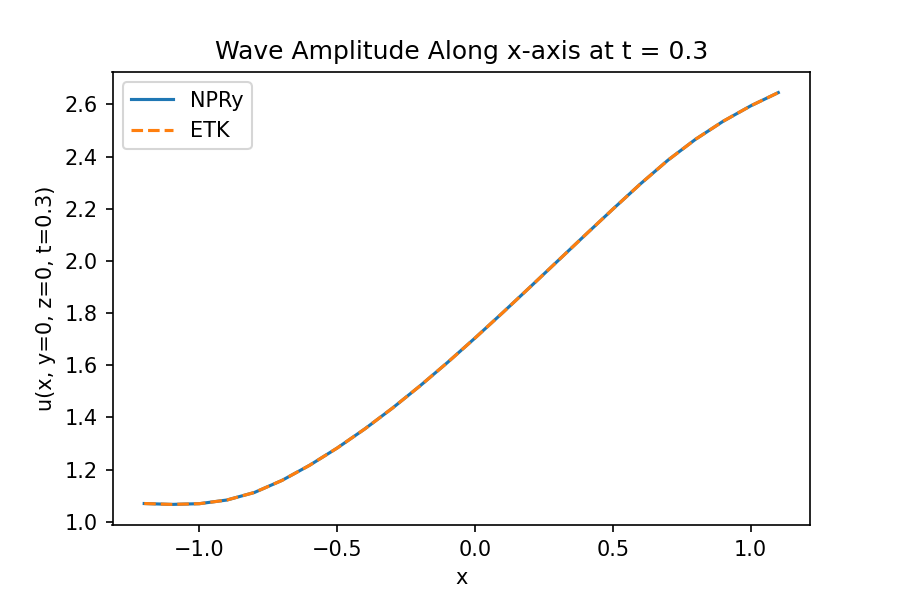

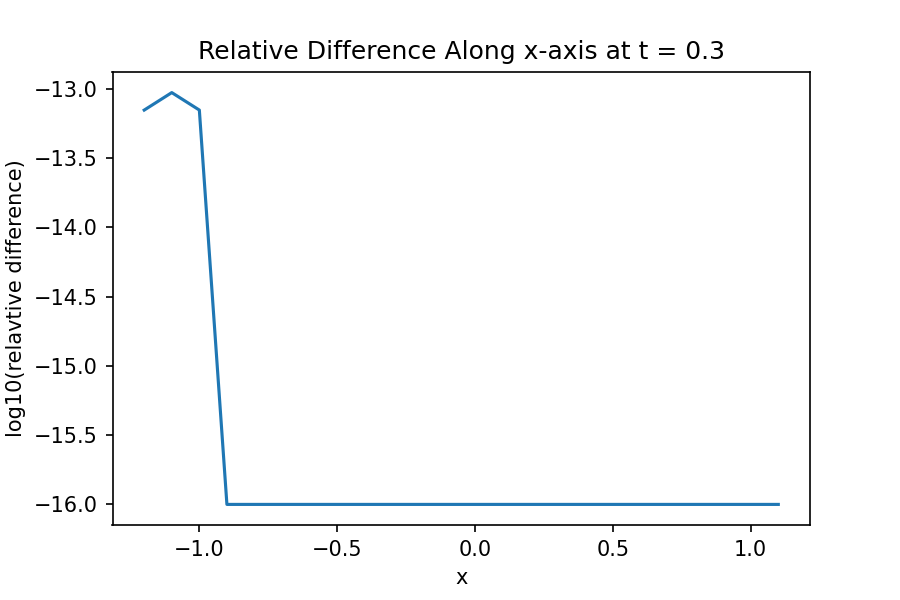

In [15]:
from IPython.display import Image
from IPython.display import display

x_axis_plot = Image("SommerfeldBoundaryCondition/NRPy_vs_ETK_x-axis.png", width=400, height=400)
E_relx_axis_plot = Image("SommerfeldBoundaryCondition/E_rel_x-axis.png", width=400, height=400)
display(x_axis_plot,E_relx_axis_plot)

Lastly we show validation results for the case of a scalar wave propagating along the -x, -y, +z diagonal, and taking a slice along the y-axis at x=z=0 (initial data, documented [here](Tutorial-ScalarWave.ipynb), with kk0 = -1, kk1 = -1, kk2 = 1), overlaying $u\left(x=0, y,z=0,t=0.3\right)$ from the ETK thorn and from NRPy+, and plotting the relative difference between the two.


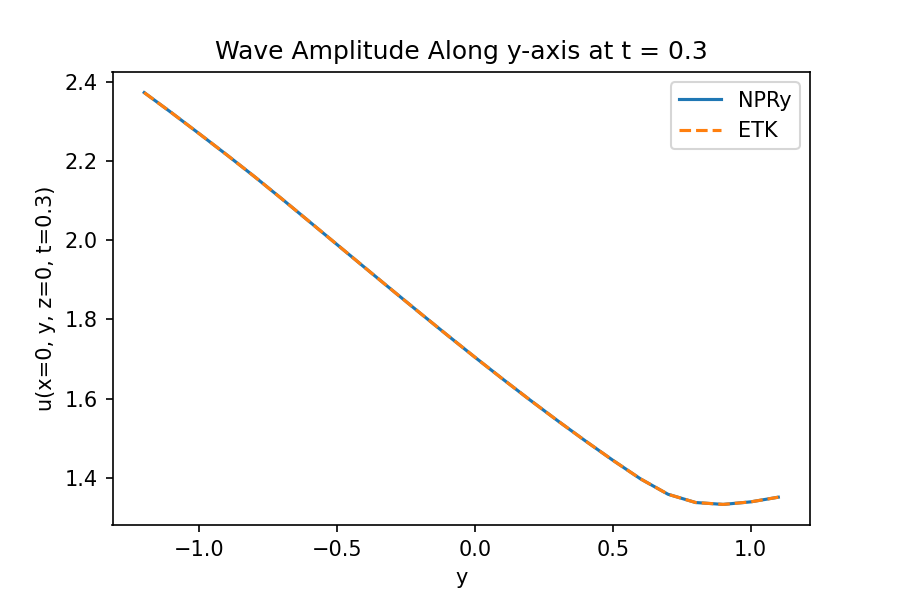

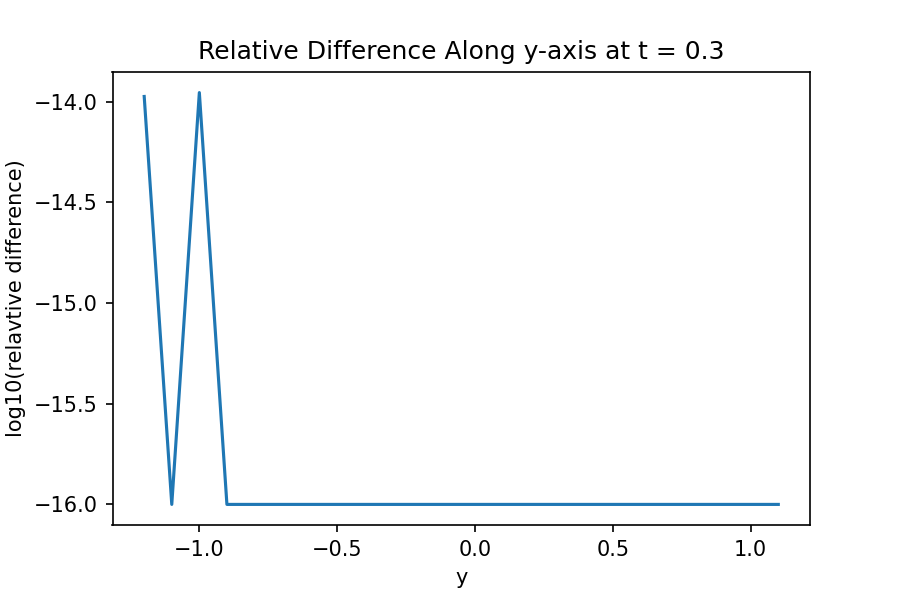

In [16]:
diagonal = Image("SommerfeldBoundaryCondition/NRPy_vs_ETK_diagonal.png", width=400, height=400)
E_rel_diagonal = Image("SommerfeldBoundaryCondition/E_rel_diagonal.png", width=400, height=400)
display(diagonal, E_rel_diagonal)

<a id='latex_pdf_output'></a>

# Step 7: Output this notebook to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{latex_pdf_output}$$

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[Tutorial-SommerfeldBoundaryCondition.pdf](Tutorial-SommerfeldBoundaryCondition.pdf) (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

In [17]:
cmd.output_Jupyter_notebook_to_LaTeXed_PDF("Tutorial-SommerfeldBoundaryCondition")

Created Tutorial-SommerfeldBoundaryCondition.tex, and compiled LaTeX file
    to PDF file Tutorial-SommerfeldBoundaryCondition.pdf
